In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../scripts/')

from proj1_helpers import *
from implementations import *
from plots import *

import numpy as np
import pandas as pd

# Data exploration 

In [4]:
train = pd.read_csv('../data/train.csv')
print(train.info())

train = train.set_index('Id')
train_tx = train[list(filter(lambda c: c != 'Prediction', list(train)))]
train_y = train['Prediction']

train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 32 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Id                           250000 non-null  int64  
 1   Prediction                   250000 non-null  object 
 2   DER_mass_MMC                 250000 non-null  float64
 3   DER_mass_transverse_met_lep  250000 non-null  float64
 4   DER_mass_vis                 250000 non-null  float64
 5   DER_pt_h                     250000 non-null  float64
 6   DER_deltaeta_jet_jet         250000 non-null  float64
 7   DER_mass_jet_jet             250000 non-null  float64
 8   DER_prodeta_jet_jet          250000 non-null  float64
 9   DER_deltar_tau_lep           250000 non-null  float64
 10  DER_pt_tot                   250000 non-null  float64
 11  DER_sum_pt                   250000 non-null  float64
 12  DER_pt_ratio_lep_tau         250000 non-null  float64
 13 

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
Id,,,,,,,,,,,,,,,,,,,,,
100000,s,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
100001,b,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
100002,b,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
100003,b,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
100004,b,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


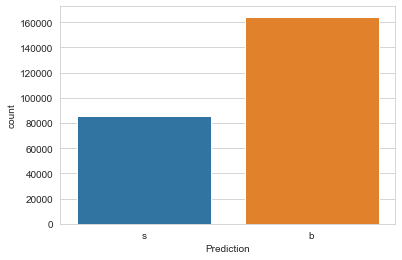

In [45]:
pred_cat = list(train['Prediction'].unique())
num_cat = len(pred_cat)

fig, ax = plt.subplots()

sns.countplot(x='Prediction', data=train, ax=ax);

- Unbalanced classes
- The relevant class s (signal) is underrepresented

## Pick some random variable for visualisations to examine distribution and class imbalance

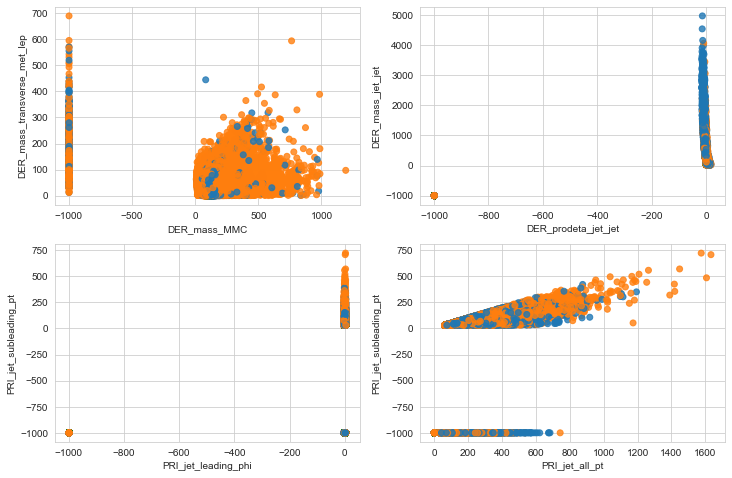

In [40]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
ax = ax.flatten()

catcolors = {ct: cc for ct, cc in zip(pred_cat, colors[:num_cat])}

x = 'DER_mass_MMC'
y = 'DER_mass_transverse_met_lep'
ax[0].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[0].set(xlabel=x, ylabel=y)

x = 'DER_prodeta_jet_jet'
y = 'DER_mass_jet_jet'
ax[1].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[1].set(xlabel=x, ylabel=y);

x = 'PRI_jet_leading_phi'
y = 'PRI_jet_subleading_pt'
ax[2].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[2].set(xlabel=x, ylabel=y);

x = 'PRI_jet_all_pt'
y = 'PRI_jet_subleading_pt'
ax[3].scatter(train[x], train[y], c=train['Prediction'].map(catcolors), alpha=.8)
ax[3].set(xlabel=x, ylabel=y);

- Need to do some outlier cleaning or find robust method
- No obvious correlations between single features and target varible
- Dataset seems highly skewed

# Feature Selection

## 0 Feature importance analysis

In [5]:
train['Prediction_enc'] = train['Prediction'].map({'s': 1, 'b':-1})
corr_y = train.corr()['Prediction_enc']

corr_y = corr_y.drop('Prediction_enc')

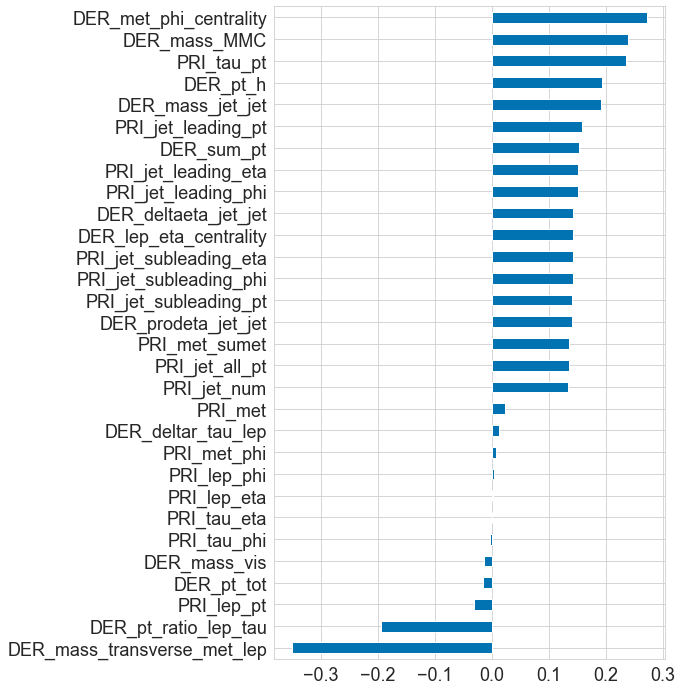

In [7]:
f, ax = plt.subplots(figsize=(7, 12))

corr_y.sort_values().plot.barh();

In [60]:
least_informative = list(corr_y[abs(corr_y) < 0.1].index)

# Get indices of least-informative features in x array
[list(train).index(c)-1 for c in least_informative]

[2, 7, 8, 14, 15, 16, 17, 18, 19, 20]

## 1 Find highly-correlated features

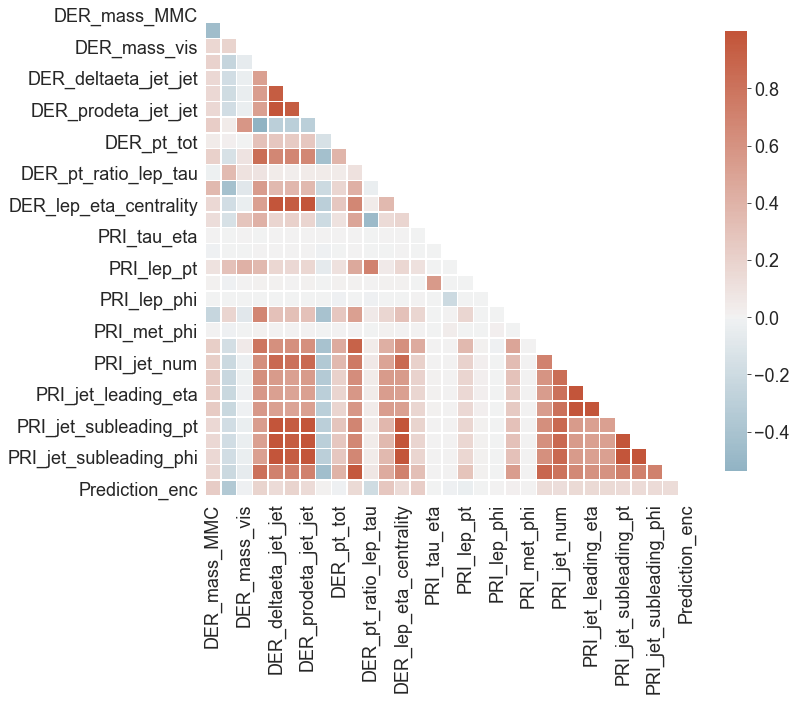

In [59]:
corr = train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9});

In [29]:
y = np.array([0, 1, 1, 0])
labels = set(y)

if len(labels.difference(set([1. , 0.]))) > 0:
    print('Re-code class labels as {0, 1}')

In [55]:
y = np.array([-1., 1., 1., -1.])
labels = set(y)
assert len(labels) == 2, "More than two classes detected. Function implements binary classification only."

if len(labels.difference(set([1 , 0]))) > 0:
    print('Re-code class labels as {0, 1}')
    
    # Get new class label encodings
    c = list(labels)
    c.sort()
    
    ty = y.copy()
    ty[ty == c[0]] = 0
    ty[ty == c[1]] = 1
y, ty

Re-code class labels as {0, 1}


(array([-1.,  1.,  1., -1.]), array([0., 1., 1., 0.]))

In [53]:
list(labels).sort()

In [47]:
list(c)[0]

-1.0